# Custom Stable Diffusion Sampling Loop with Classifier-Free Guidance

This notebook implements a custom Stable Diffusion inference loop using Classifier-Free Guidance.  
It generates images from text prompts using Hugging Face `diffusers` and a custom denoising loop.

#LIBRARIES

In [1]:
!pip install torch transformers diffusers tqdm pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
from tqdm import tqdm
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from PIL import Image
import numpy as np

#LOAD MODELS

Load tokenizer and text encoder

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda").half()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Load UNet and VAE models

In [4]:
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to("cuda").half()
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to("cuda").half()

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Load scheduler

In [5]:
scheduler = LMSDiscreteScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

#Prompts and parameters

In [44]:
prompts = ['Cartoon-style avocado character', 'An avocado painted in the style of Van Gogh']

In [45]:
guidance_scale = 7.5
num_inference_steps = 50
height, width = 512, 512
torch.manual_seed(100)

#Tokenization and embeddings

Tokenize text prompts

In [8]:
text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

Tokenize negative prompts

In [10]:
negative_prompts = ['blurry, low quality, extra limbs'] * len(prompts)
uncond_input = tokenizer(negative_prompts, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()


Concatenate for classifier-free guidance

In [11]:
emb = torch.cat([uncond_embeddings, text_embeddings])

#Initialize latents

In [46]:
latents = torch.randn((len(prompts), unet.in_channels, height // 8, width // 8), device="cuda").half()
scheduler.set_timesteps(num_inference_steps)
latents *= scheduler.init_noise_sigma

/tmp/ipython-input-46-3427518991.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((len(prompts), unet.in_channels, height // 8, width // 8), device="cuda").half()


#Loop sampling

In [52]:
for i, ts in enumerate(tqdm(scheduler.timesteps[:-1])):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

    with torch.no_grad():
        u, t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

    pred = u + guidance_scale * (t - u)
    latents = scheduler.step(pred, i, latents).prev_sample

    if i % 10 == 0:
        with torch.no_grad():
            partial_image = vae.decode(1 / 0.18215 * latents).sample
        img_np = (partial_image[0].cpu().permute(1, 2, 0).numpy() / 2 + 0.5).clip(0, 1)
        Image.fromarray((img_np * 255).astype("uint8")).save(f"outputs/step_{i}.png")


100%|██████████| 49/49 [00:17<00:00,  2.87it/s]


##Decode images

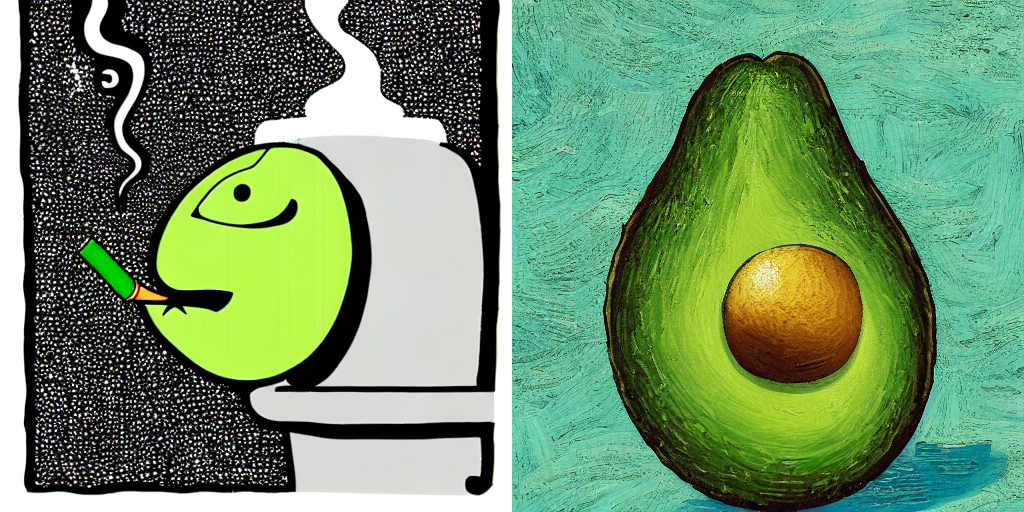

In [53]:
with torch.no_grad():
    image = vae.decode(1 / 0.18215 * latents).sample

res = (image / 2 + 0.5).clamp(0, 1)

img0 = res[0].detach().cpu().permute(1, 2, 0).numpy()
img1 = res[1].detach().cpu().permute(1, 2, 0).numpy()

concat = np.concatenate([img0, img1], axis=1)
image = (concat * 255).round().astype("uint8")

Image.fromarray(image)

In [58]:
img1_uint8 = (img1 * 255).round().astype("uint8")
Image.fromarray(img1_uint8).save("outputs/avocado_vg.png")

## Conclusions

This notebook successfully implements a custom sampling loop for Stable Diffusion using Classifier-Free Guidance.  
Possible improvements:
- Test with different samplers (DDIM, Euler, DPM)
- Adjust guidance_scale and inference steps
- Add more complex negative prompts
- Integrate interactive prompt input

In [59]:
!pip install nbstripout
!nbstripout --strip-notebook custom_diffusion_sampling.ipynb

usage: nbstripout [-h]
                  [--dry-run | --install | --uninstall | --is-installed | --status | --version]
                  [--verify] [--keep-count] [--keep-output] [--keep-id]
                  [--extra-keys EXTRA_KEYS]
                  [--keep-metadata-keys KEEP_METADATA_KEYS]
                  [--drop-empty-cells] [--drop-tagged-cells DROP_TAGGED_CELLS]
                  [--strip-init-cells] [--attributes FILEPATH]
                  [--global | --system | --python PATH] [--force]
                  [--max-size SIZE] [--mode {jupyter,zeppelin}] [--textconv]
                  [files ...]
nbstripout: error: unrecognized arguments: --strip-notebook
